# I'm Something of a Painter Myself

Kaggle Competition Notebook: https://www.kaggle.com/competitions/gan-getting-started/overview


## Step One: Project Overview


In this project, we want to build a GAN so that we can tell the difference between a real photo and a painting by Monet. In the process we'll also work to generate images that are stylized to look like Monet paintings. Before we get started, let's talk a little more about GANs. 


A Generative Adversarial Network (GAN) is a type of deep learning model that is typically used to generate data that mimics data from the input set. 
Typically a GAN is made up of two neural networks including a generator and a discriminator. 
Generally speaking, there is an input dataset of "real" data and a set of "fake" data, generated by the generator, that is fed to the discriminator, whose job is to classify the data as being real or fake. 

Training is basically the two networks playing a game against each other (hence the 'adversarial' part of GAN). The discriminator's goal is to learn how to reliably pick the real image, while the generator's goal is to fool the generator so it picks the fake image. At the beginning of training generators are really producing random noise and the discriminator is making random guesses. But as training continues, the results of who wins/loses is fed back to each model to help it learn how to either pick images better or generate images better. The process continues until the generator is able to reliably fool the discriminator. 

### Helpful resources: 
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
- https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/
- https://www.youtube.com/watch?v=_qB4B6ttXk8
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

## Step Two: Exploratory Data Analysis & Data Preparation

### Loading Kaggle Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

file_dirs = os.listdir("/kaggle/input/gan-getting-started/")
for d in file_dirs:
    files = os.listdir(f"/kaggle/input/gan-getting-started/{d}")
    print(f"Directory [{d}] has [{len(files)}] images.")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Directory [monet_jpg] has [300] images.
Directory [photo_tfrec] has [20] images.
Directory [photo_jpg] has [7038] images.
Directory [monet_tfrec] has [5] images.


From the above we can see we have access to 4 directories. 
- `monet_jpg` and `photo_jpg` contain `.jpg` images that we can use to build and train the model that we'll use to generate images from
- The `photo_tfrec` and `monet_tfrec` directories contain [TFRecord files](https://www.tensorflow.org/tutorials/load_data/tfrecord/)

Next we can load the data to see how it is structured - for this section I used Amy Jang's [tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) to help understand how to load the data. 

In [2]:
import tensorflow as tf
from tensorflow import keras

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2024-02-25 06:23:26.139761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 06:23:26.139908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 06:23:26.316973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.15.0


In [3]:
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
monet_dir = "/kaggle/input/gan-getting-started/monet_jpg"
photo_dir = "/kaggle/input/gan-getting-started/photo_jpg"
monet_rec_dir = "/kaggle/input/gan-getting-started/monet_tfrec"
photo_rect_dir = "/kaggle/input/gan-getting-started/photo_tfrec"

IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3

# Records contain the image_name, image and target
def parse_record_and_image(record):
    features = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_record = tf.io.parse_single_example(record, features)
    # Process image
    image = tf.image.decode_jpeg(parsed_record['image'], channels=3) 
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def load_images(tfrec_dir: str):
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrec_dir, "*.tfrec"))
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    return dataset.map(parse_record_and_image, num_parallel_calls=AUTOTUNE)    


In [4]:
monet = load_images(monet_rec_dir).batch(1)
photo = load_images(photo_rect_dir).batch(1)

In [5]:
monet

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [6]:
# Image Helpers: 
import seaborn as sns
from matplotlib.gridspec import GridSpec

def show_image_basic(image):
    plt.axis('off')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().imshow(image*0.5+0.5)
    
def show_image_by_channel(image, show_dist:bool = False):
    channels = {
        'red': image[:,:,0],
        'green':image[:,:,1],
        'blue':image[:,:,2],
    }
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 0.5, 0.5])
    ax_kde = fig.add_subplot(gs[1, :])
    # Plot images in the top row
    for i, channel in enumerate(channels):
        ax_img = fig.add_subplot(gs[0, i])
        ax_img.imshow(channels[channel], cmap=channel.capitalize()+"s")
        ax_img.set_title(f'{channel.capitalize()} Channel')
        ax_img.axis('off')

        channel_data = channels[channel].numpy().ravel()
        sns.kdeplot(channel_data, color=channel, ax=ax_kde)
        
        if show_dist:
            ax_hist = fig.add_subplot(gs[2, i])
            ax_hist.hist(channel_data, bins=64, range=(-1, 1), color=channel, alpha=0.5)
            ax_hist.grid(True, alpha=0.5)
            ax_hist.set_yticklabels([])
            
            ax_kde.set_title('Pixel Density by Channel')
            ax_kde.set_xlabel('Pixel Value')
            ax_kde.set_ylabel('Density')
            ax_kde.legend([f'{channel.capitalize()} Channel' for channel in channels])
            ax_kde.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


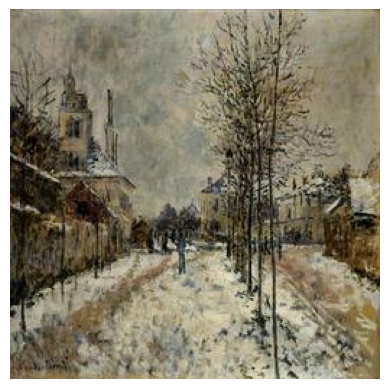

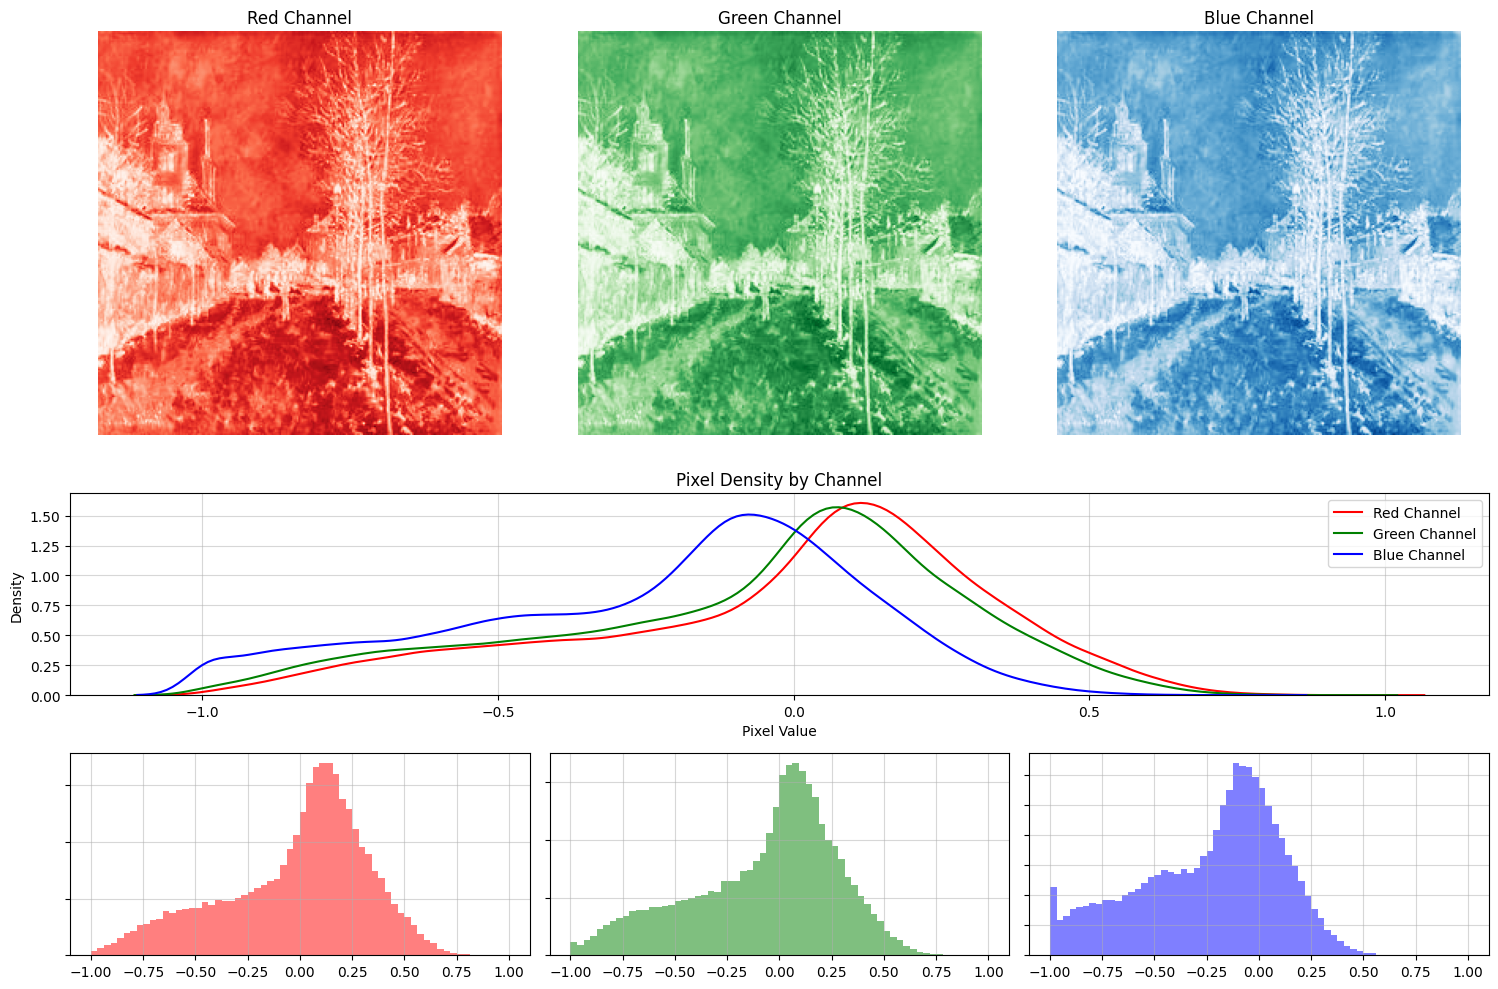

In [7]:
example_monet = next(iter(monet))
show_image_basic(example_monet[0])
show_image_by_channel(example_monet[0], show_dist = True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


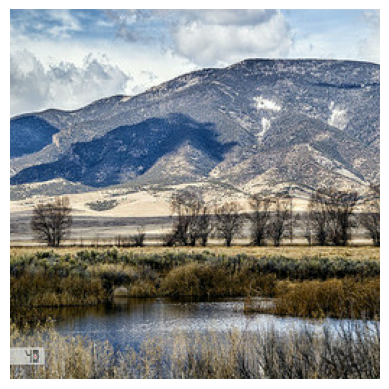

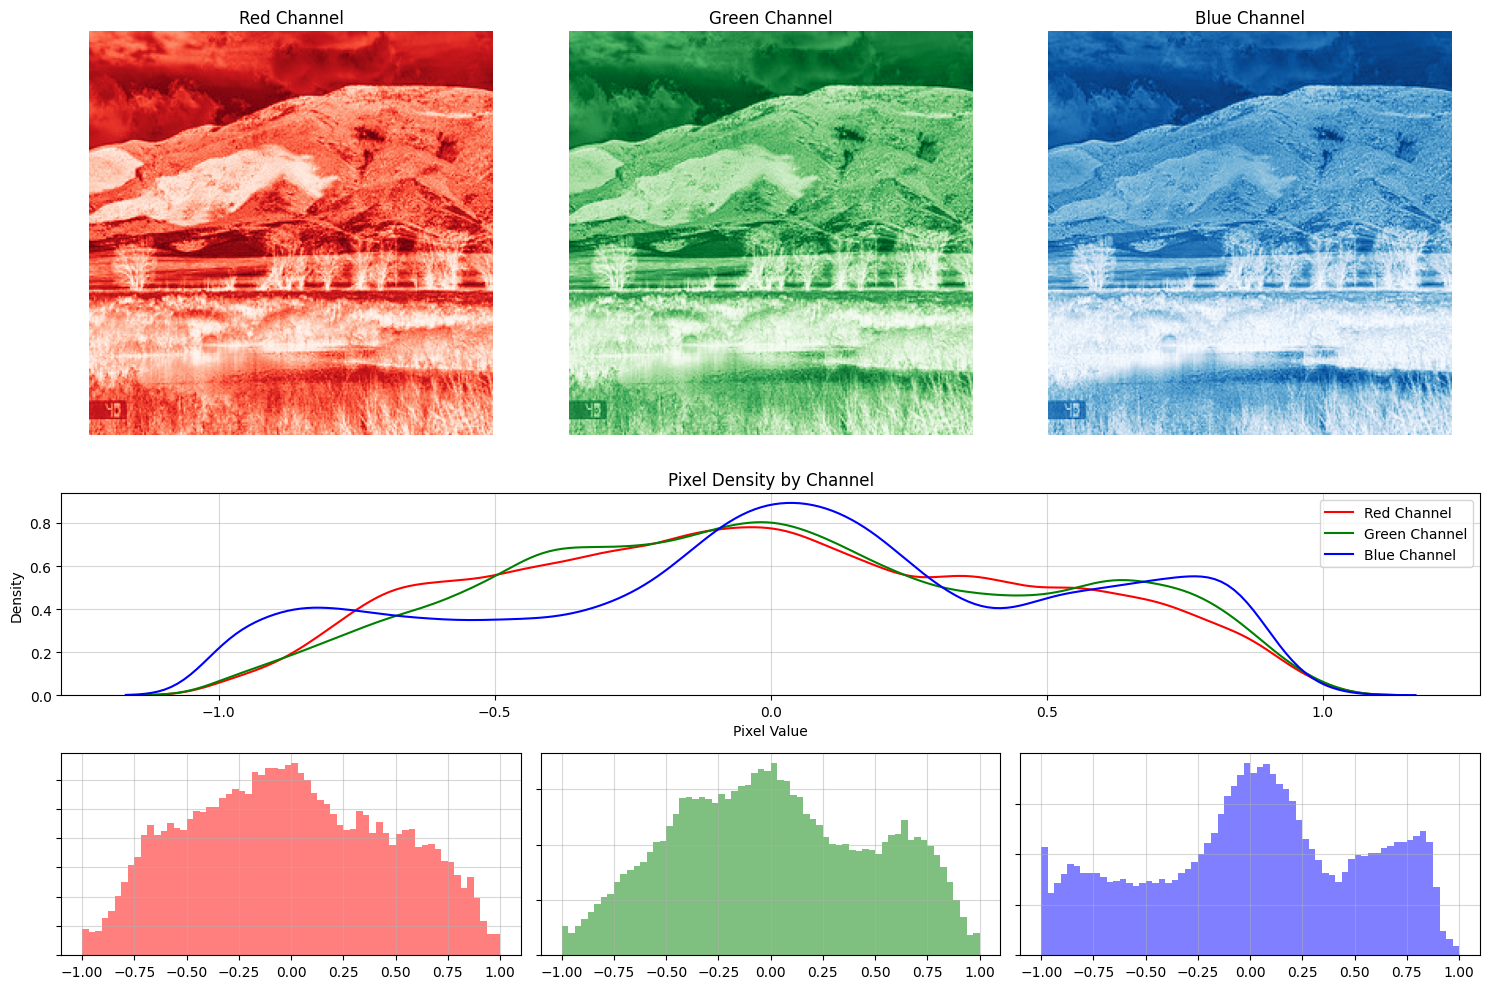

In [8]:
example_photo = next(iter(photo))
show_image_basic(example_photo[0])
show_image_by_channel(example_photo[0], show_dist = True)

## Step Three: Model Architecture

TODO: Add description of approach


Build generator, then build discriminator then train.

In our case a cycle GAN is probably the best appraoch. The idea behind a cycle gan is to try and take characteristics from one image and embed them into another, which is exactly what we want to do. We can also make use of the PatchGAN discriminator. 

The architecture I'm planning to use is further outlined [here](https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/) 

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
OUTPUT_CHANNELS = 3

# Initial code from Amy Jang Notebook - trying to understand how this works so I can implement my own 

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

#     if apply_instancenorm:
#         result.add(InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

#     result.add(InstanceNormalization(gamma_initializer=gamma_init)) -> should be able to get a version of this from Tensorflow Examples for reference: https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py#L161C1-L186C1

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


print(Generator().summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131072    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          524288    ['sequential_1[0][0]']        
                                                                                              

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

#     norm1 = InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
# with strategy.scope():
#     monet_generator = Generator() # transforms photos to Monet-esque paintings
#     photo_generator = Generator() # transforms Monet paintings to be more like photos

#     monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
#     photo_discriminator = Discriminator()

In [12]:
# photo_to_monet= monet_generator(example_photo)                # won't generate monet-esque photos as we have not fit the data into generator yet

# plt.subplot(1,2,1)                                       # creating a subplot with 1 row and 2 columns
# plt.title('Original Photo')
# plt.imshow(example_photo[0]*0.5 +0.5)                         # rescaling the image to [0,1] for displaying

# plt.subplot(1,2,2)
# plt.title('Generated Monet-esque photo')
# plt.imshow(photo_to_monet[0]*0.5 +0.5)     

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In order to make use of this we need to also define the following:
m_gen_optimizer,
p_gen_optimizer,
m_disc_optimizer,
p_disc_optimizer,
gen_loss_fn,
disc_loss_fn,
cycle_loss_fn,
identity_loss_fn

In [14]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [15]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [16]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [17]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [18]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
gen_loss_fn = generator_loss
disc_loss_fn = discriminator_loss
cycle_loss_fn = calc_cycle_loss
identity_loss_fn = identity_loss

Now we can start training the model.

### Train Model

In [19]:
# cyclegan_model= CycleGan(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
# cyclegan_model.compile(monet_generator_optimizer, monet_discriminator_optimizer, photo_generator_optimizer, photo_discriminator_optimizer, gen_loss_fn, disc_loss_fn,  cycle_loss_fn, identity_loss_fn)

In [20]:
# cyclegan_model.fit(
#     tf.data.Dataset.zip((monet, photo)),
#     epochs=2
# )

## Step Four: Results & Analysis

## Step Five: Conclusions

### Code for Kaggle Submission